In [1]:
import pandas as pd
from datetime import date
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneGroupOut
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, average_precision_score
import lxml.etree as ET
from sklearn import ensemble, metrics
import numbers
import pickle
import os

In [2]:
df_known_dt = pd.read_csv("../data/opentargets/known_drugs_targets.csv")
df_drugs = pd.read_csv("../data/opentargets/drugs_embeddings.csv")
df_targets = pd.read_csv("../data/opentargets/targets_embeddings.csv")

In [3]:
def generate_dt_pairs(dt_df):
    """Get pairs and their labels: All given known drug-target pairs are 1,
    We add pairs for missing drug/targets combinations as 0 (not known as interacting)"""
    dtKnown = {tuple(x) for x in dt_df[["drug", "target"]].values}
    pairs = []
    labels = []

    drugs = set(dt_df.drug.unique())
    targets = set(dt_df.target.unique())
    for d in drugs:
        for t in targets:
            label = 1 if (d, t) in dtKnown else 0

            pairs.append((d, t))
            labels.append(label)

    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs, labels

In [4]:
def balance_data(pairs, classes, n_proportion=1):
    classes = np.array(classes)
    pairs = np.array(pairs)

    indices_true = np.where(classes == 1)[0]
    indices_false = np.where(classes == 0)[0]

    np.random.shuffle(indices_false)
    indices = indices_false[: (n_proportion * indices_true.shape[0])]

    print(f"True positives: {len(indices_true)}")
    print(f"True negatives: {len(indices_false)}")
    pairs = np.concatenate((pairs[indices_true], pairs[indices]), axis=0)
    classes = np.concatenate((classes[indices_true], classes[indices]), axis=0)

    return pairs, classes

In [5]:
def count_drugbank_entries(df_merged):
    count_null = 0
    count_db_prefix = 0

    for entry in df_merged['drugbankId']:
        if entry == 'null':
            count_null += 1
        else:
            count_db_prefix += 1

    return count_null, count_db_prefix

In [6]:
def parse_drugbank_xml(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    ns = {'db': 'http://www.drugbank.ca'}

    atc_codes = []
    drugbank_ids = []

    for drug in root.findall('db:drug', ns):
        drugbank_id = drug.find('db:drugbank-id', ns).text if drug.find('db:drugbank-id', ns) is not None else 'No ID'
        
        atc_code_elements = drug.findall('db:atc-codes/db:atc-code', ns)
        codes = [code.get('code') for code in atc_code_elements] if atc_code_elements else ['No ATC Code']

        drugbank_ids.append(drugbank_id)
        atc_codes.append(', '.join(codes))
    
    return pd.DataFrame({'DrugBank ID': drugbank_ids, 'ATC Codes': atc_codes})

In [7]:
def assign_groups(df, column_name):
    atc_to_group = {}
    group_id = 0
    
    for index, row in df.iterrows():
        codes = row[column_name]
        
        if codes not in atc_to_group:
            atc_to_group[codes] = group_id
            group_id += 1
        
        df.at[index, 'group'] = atc_to_group[codes]
    
    return df

In [8]:
def get_groups_array(pairs, print_groups=False):

    if print_groups:
        print("Pairs shape ", len(pairs))

    df_tsv = pd.read_csv('../data/full database/drug-mappings.tsv', sep='\t')
    df_mappings = df_tsv[['drugbankId', 'chembl_id']]

    if print_groups:
        print("Mappings shape ", df_mappings.shape)
        print("Duplicated sum ", df_mappings['chembl_id'].duplicated().sum())

    df_mappings = df_mappings.drop_duplicates(subset=['chembl_id'])

    df_second = pd.DataFrame(pairs)

    df_second.columns = ['chembl_compound', 'uniprot_id']

    df_second['chembl_id'] = df_second['chembl_compound'].apply(lambda x: x.split(':')[-1])

    if print_groups:
        print("Second shape ", df_second.shape)

    df_merged = pd.merge(df_second, df_mappings, on='chembl_id', how='left')
    
    df_merged.drop('chembl_id', axis=1, inplace=True)

    df_merged['drugbankId'] = df_merged['drugbankId'].fillna('null')

    if print_groups:
        print("Merged shape ", df_merged.shape)

    null_count, db_prefix_count = count_drugbank_entries(df_merged)

    if print_groups:
        print(f"Number of 'null' entries: {null_count}")
        print(f"Number of entries starting with 'DB': {db_prefix_count}")
        print(df_merged.head())

    df_drugbank_id_atc_code = parse_drugbank_xml('../data/full database/full_database.xml')
    
    if print_groups:
        print("Drugbank ID ATC Code shape ", df_drugbank_id_atc_code.shape)

    df_drugbank_id_atc_code['ATC Codes'] = df_drugbank_id_atc_code['ATC Codes'].apply(lambda x: x if x == 'No ATC Code' else x.split(',')[0][0])
    df_drugbank_id_atc_code = df_drugbank_id_atc_code.rename(columns={'ATC Codes': 'First letter ATC Codes'})
    df_drugbank_id_atc_code = df_drugbank_id_atc_code.rename(columns={'DrugBank ID': 'drugbankId'})

    if print_groups:
        print("Drugbank ID ATC Code shape ", df_drugbank_id_atc_code.shape)

    x = pd.merge(df_merged, df_drugbank_id_atc_code, on='drugbankId', how='left')

    df_groups = assign_groups(x, 'First letter ATC Codes')

    if print_groups:
        group_counts = df_groups['group'].value_counts(normalize=True) * 100
        all_groups = pd.Series(range(15))
        group_percentages = all_groups.map(group_counts).fillna(0)
        for group, percentage in group_percentages.items():
            print(f"Group {group}: {percentage:.2f}%")
    
    df_groups['group'] = df_groups['group'].astype(int)
    groups_array = df_groups['group'].values
    return groups_array

In [9]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

In [10]:
def multimetric_score(estimator, X_test, y_test, scorers):
    """Return a dict of score for multimetric scoring"""
    scores = {}
    for name, scorer in scorers.items():
        score = scorer(estimator, X_test) if y_test is None else scorer(estimator, X_test, y_test)

        if hasattr(score, "item"):
            try:
                # e.g. unwrap memmapped scalars
                score = score.item()
            except ValueError:
                # non-scalar?
                pass
        scores[name] = score

        if not isinstance(score, numbers.Number):
            raise ValueError(
                f"scoring must return a number, got {score!s} ({type(score)}) " f"instead. (scorer={name})"
            )
    return scores

In [11]:
def get_scores(clf, X_new, y_new):
    scoring = ["precision", "recall", "accuracy", "roc_auc", "f1", "average_precision"]
    scorers = metrics._scorer._check_multimetric_scoring(clf, scoring=scoring)
    scores = multimetric_score(clf, X_new, y_new, scorers)
    return scores

In [12]:
def crossvalid(train_df, test_df, clfs, run_index, fold_index):
    features_cols = train_df.columns.difference(["drug", "target", "Class"])
    print(f"Features count: {len(features_cols)}")
    X = train_df[features_cols].values
    y = train_df["Class"].values.ravel()

    X_new = test_df[features_cols].values
    y_new = test_df["Class"].values.ravel()

    print("FIT X Y")
    print(X)
    print(y)
    print(len(X), len(y))

    results = pd.DataFrame()
    for name, clf in clfs:
        clf.fit(X, y)
        row = {}
        row["run"] = run_index
        row["fold"] = fold_index
        row["method"] = name
        scores = get_scores(clf, X_new, y_new)
        row.update(scores)

        df = pd.DataFrame.from_dict([row])
        results = pd.concat([results, df], ignore_index=True)

    return results  # , sclf_scores

In [13]:
def cv_run(run_index, pairs, classes, embedding_df, train, test, fold_index, clfs):
    # print( f"Run: {run_index} Fold: {fold_index} Train size: {len(train)} Test size: {len(test)}")
    train_df = pd.DataFrame(
        list(zip(pairs[train, 0], pairs[train, 1], classes[train])), columns=["drug", "target", "Class"]
    )
    test_df = pd.DataFrame(
        list(zip(pairs[test, 0], pairs[test, 1], classes[test])), columns=["drug", "target", "Class"]
    )

    train_df = train_df.merge(embedding_df["drug"], left_on="drug", right_on="drug").merge(
        embedding_df["target"], left_on="target", right_on="target"
    )
    test_df = test_df.merge(embedding_df["drug"], left_on="drug", right_on="drug").merge(
        embedding_df["target"], left_on="target", right_on="target"
    )

    all_scores = crossvalid(train_df, test_df, clfs, run_index, fold_index)
    if run_index == 1 and fold_index == 0:
        print(", ".join(all_scores.columns))
    print(all_scores.to_string(header=False, index=False))

    return all_scores

In [14]:
def group_cv(pairs_all, classes_all, embedding_df, clfs):
    pairs, classes = balance_data(pairs_all, classes_all)

    groups = get_groups_array(pairs, False)

    # sorting needed of LeaveOneGroupOut()
    sorted_indices = np.argsort(groups)
    pairs_s, classes_s, groups_s = pairs[sorted_indices], classes[sorted_indices], groups[sorted_indices]

    logo  = LeaveOneGroupOut()
    
    fig, ax = plt.subplots()
    plot_cv_indices(logo , pairs_s, classes_s, groups_s, ax, np.max(groups_s) + 1 + 2)
    filename = f'LOGO.png'
    plt.savefig(filename)

    cv = logo.split(pairs_s, classes_s, groups_s)
    cv_list = [(train, test, k) for k, (train, test) in enumerate(cv)]
    print('cv list')
    print(cv_list)

    all_scores = pd.DataFrame()
    for fold in cv:
        scores = cv_run(0, pairs_s, classes_s, embedding_df, fold[0], fold[1], fold[2], clfs)
        all_scores = pd.concat([all_scores, scores], ignore_index=True)

    scores_df = pd.DataFrame()
    scores_df = pd.concat([scores_df, all_scores], ignore_index=True)
    
    return scores_df

Training based on 8777 Drug-Targets known interactions: 3229 drugs | 1475 targets
True positives: 8777
True negatives: 3715855
cv list
[(array([  959,   960,   961, ..., 17551, 17552, 17553]), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144

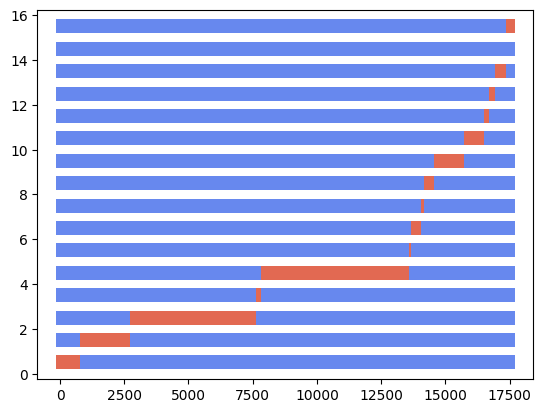

In [15]:
today = date.today()
results_file = f"openpredict_drug_targets_scores_{today}.csv"
pairs, labels = generate_dt_pairs(df_known_dt)
unique, counts = np.unique(labels, return_counts=True)
ndrugtargets = counts[1]
print(f"Training based on {ndrugtargets} Drug-Targets known interactions: {len(df_drugs)} drugs | {len(df_targets)} targets")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=None, #config.max_depth,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    objective='binary:logistic',  # For binary classification
    n_jobs=-1,
    random_state=42,
    tree_method='hist', # Use GPU optimized histogram algorithm
    #device='gpu',
)
clfs = [("XGBoost", xgb_model)] # "Random Forest", rf_model
n_seed = 100
n_fold = 10
n_run = 2
sc = None
embeddings = {
    "drug": df_drugs,
    "target": df_targets,
}
all_scores_df = group_cv(pairs, labels, embeddings, clfs)
print('all scores df columns ', all_scores_df.columns)
all_scores_df.to_csv(results_file, sep=",", index=False)

# agg_df = all_scores_df.groupby(["method", "run"]).mean().groupby("method").mean()
# agg_df.to_csv(agg_results_file, sep=",", index=False)
# log.info("Aggregated results:")
# print(agg_df)

os.makedirs("models_new", exist_ok=True)
with open("drug_target.pkl", "wb") as f:
    pickle.dump(xgb_model, f) # rf_model